In [7]:
# Cell 1: 라이브러리 및 설정
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer # 필요시 기본 결측치 처리
from sklearn.ensemble import RandomForestRegressor # HB 결측치 처리용
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib # 스케일러/임퓨터 저장용

# 데이터 경로 정의 (파일명 확인)
data_path = "/Users/yeojoon/Documents/PyWorkspace_CreativeDesign/Materiadata0411.xlsx"

# 장치 설정 (가능하면 GPU, 아니면 CPU 사용)
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"사용 장치: {device}")

# 재현성을 위한 랜덤 시드 설정
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
if device == 'cuda':
    torch.cuda.manual_seed(seed)
elif device == 'mps':
     # MPS는 현재 CUDA와 같은 전용 랜덤 시드 함수가 없음
     # torch.manual_seed는 MPS 작업의 CPU 부분을 처리함
     pass

print("라이브러리 임포트 및 설정 완료.")


사용 장치: mps
라이브러리 임포트 및 설정 완료.


In [8]:
# Cell 2: 데이터 로딩 및 초기 검사

try:
    # 'Tensile' 시트 로드
    df_tensile = pd.read_excel(data_path, sheet_name='Tensile', header=0)
    print("--- Tensile 시트 ---")
    print(f"형태: {df_tensile.shape}")
    print("\n컬럼:", df_tensile.columns.tolist())
    print("\n처음 5행:\n", df_tensile.head())
    print("\n데이터 타입:\n", df_tensile.dtypes)
    print("\n결측치 요약:\n", df_tensile.isnull().sum())

    # (선택사항) 나중에 필요할 경우 'Shear' 시트 로드
    # df_shear = pd.read_excel(data_path, sheet_name='Shear', header=0)
    # print("\n--- Shear 시트 ---")
    # print(f"형태: {df_shear.shape}")
    # print("컬럼:", df_shear.columns.tolist())

except FileNotFoundError:
    print(f"오류: {data_path}에서 파일을 찾을 수 없습니다")
except Exception as e:
    print(f"데이터 로딩 중 오류 발생: {e}")

# 다음 항목에 대한 정확한 컬럼명 식별:
# E, YS, TS, HB, HV (존재하는 경우), spf, b, epf, c, (선택사항: np, Kp)
# 위의 출력을 기반으로 식별된 컬럼명을 명확히 하기 위해 여기에 나열합니다.
# 예시:
# e_col = 'Elastic Modulus (GPa)'
# ys_col = 'YS (MPa)'
# ts_col = 'UTS (MPa)'
# hb_col = 'HB'
# hv_col = 'HV' # 이 컬럼이 존재하는지 확인
# spf_col = "sigma_f' (MPa)"
# b_col = 'b'
# epf_col = "epsilon_f'"
# c_col = 'c'
# np_col = "n'" # 선택사항
# kp_col = "K' (MPa)" # 선택사항


--- Tensile 시트 ---
형태: (276, 21)

컬럼: [' 실험수', 'Material', 'HeatTreatment', 'nothing', 'E', 'YS', 'TS', 'EL', 'RA', 'K', 'n', 'HV', 'HB', 'sy', 'np', 'Kp', 'sf', 'b', 'ef', 'c', '특이사항']

처음 5행:
    실험수 Material HeatTreatment nothing      E   YS     TS    EL   RA      K  \
0  NaN   0.6040           NaN     NaN  140.0  420  570.0   NaN  NaN  902.0   
1  NaN   0.7040           NaN     NaN  165.0  323  470.0  17.3  NaN  514.0   
2  NaN   0.7060           NaN     NaN  158.0  382  632.0   7.0  NaN  507.0   
3  NaN   0.7060           NaN     NaN  175.0  480  738.0   4.4  NaN    NaN   
4  NaN   0.8155           NaN     NaN  155.0  389  600.0   5.0  NaN  582.0   

   ...   HV  HB  sy     np      Kp     sf      b      ef      c  \
0  ...  NaN NaN NaN  0.153  1012.0  646.0 -0.078  0.0353 -0.451   
1  ...  NaN NaN NaN  0.065   677.0  851.0 -0.075  9.7123 -1.016   
2  ...  NaN NaN NaN  0.076   750.0  720.0 -0.058  0.7236 -0.782   
3  ...  NaN NaN NaN  0.103   936.0  805.0 -0.067  0.2314 -0.652   
4

In [9]:
# Cell 3: 컬럼 이름 변경 및 타입 변환

# --- 사용자 작업: Cell 2의 출력을 기반으로 컬럼 이름 매핑 정의 ---
# DataFrame의 정확한 컬럼 이름과 키가 일치하는지 확인
column_mapping = {
    'E': 'E_GPa', # 예시, 실제 이름에 따라 조정
    'YS': 'YS_MPa',
    'TS': 'TS_MPa',
    'HB': 'HB',
    'HV': 'HV', # HV 컬럼이 존재하는 경우 포함
    "sf": 'spf_MPa', #sigma f
    'b': 'b',
    "ef": 'epf', #epsilon_f 
    'c': 'c',
    # 사용할 경우 선택적 컬럼 추가
    # "n'": 'np',
    # "K' (MPa)": 'Kp_MPa',
    # 'Material Name', 'RA (%)' 등과 같은 다른 관련 컬럼 추가
    #'RA': 'RA_percent' # RA가 존재하고 필요한 경우 예시
}

# 사용할 계획인 컬럼만 선택하고 이름 변경
# column_mapping의 모든 키가 df_tensile.columns에 존재하는지 확인
required_cols = list(column_mapping.keys())
missing_cols = [col for col in required_cols if col not in df_tensile.columns]

if 'HV' in missing_cols and 'HV' in column_mapping:
    print("경고: HV 컬럼이 매핑에 지정되었지만 데이터에서 찾을 수 없습니다. HV 없이 진행합니다.")
    # 찾을 수 없는 경우 매핑에서 HV 제거
    column_mapping.pop('HV', None)
    required_cols.remove('HV')
    hv_col_exists = False
else:
    hv_col_exists = 'HV' in column_mapping

if any(col in missing_cols for col in ['HB', 'Elastic Modulus (GPa)', 'YS (MPa)', 'UTS (MPa)', "sigma_f' (MPa)", 'b', "epsilon_f'", 'c']):
     print(f"오류: 데이터에서 중요한 컬럼이 누락되었습니다: {[col for col in missing_cols if col != 'HV']}")
     # 실행 중지 또는 적절히 처리
else:
    df = df_tensile[list(column_mapping.keys())].copy()
    df.rename(columns=column_mapping, inplace=True)

    # 컬럼을 숫자로 변환, 오류 강제 변환(비숫자를 NaN으로 변환)
    numeric_cols = ['E_GPa', 'YS_MPa', 'TS_MPa', 'HB', 'spf_MPa', 'b', 'epf', 'c']
    if hv_col_exists:
        numeric_cols.append('HV')
    # 포함된 경우 선택적 숫자 컬럼 추가: 'np', 'Kp_MPa', 'RA_percent'
    if 'RA_percent' in df.columns: numeric_cols.append('RA_percent')
    if 'np' in df.columns: numeric_cols.append('np')
    if 'Kp_MPa' in df.columns: numeric_cols.append('Kp_MPa')


    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    print("\n이름 변경 및 숫자 변환 후 DataFrame:")
    print(df.head())
    print("\n데이터 타입:\n", df.dtypes)
    print("\n강제 변환 후 결측치 요약:\n", df.isnull().sum())

    # 잠재적 단위 문제 확인(예: E가 GPa vs MPa)
    # E가 GPa인 경우, 강도와 일관성을 위해 MPa로 변환
    if 'E_GPa' in df.columns:
        df['E_MPa'] = df['E_GPa'] * 1000
        df.drop(columns=['E_GPa'], inplace=True)
        print("\nE를 MPa로 변환했습니다('E_MPa' 컬럼 생성됨).")

    # 쉬운 참조를 위한 최종 특성 및 타겟 컬럼 이름 정의
    feature_cols = ['E_MPa', 'YS_MPa', 'TS_MPa'] # 처리 후 HB가 추가될 예정
    target_cols = ['spf_MPa', 'b', 'epf', 'c']
    # optional_target_cols = ['np', 'Kp_MPa'] # 사용하는 경우

    # 타겟 변수가 누락된 행 삭제, 이러한 행으로는 학습할 수 없음
    initial_rows = len(df)
    df.dropna(subset=target_cols, inplace=True)
    print(f"\n타겟 값({target_cols})이 누락된 {initial_rows - len(df)}개 행을 삭제했습니다.")
    print(f"남은 행: {len(df)}")



이름 변경 및 숫자 변환 후 DataFrame:
   E_GPa  YS_MPa  TS_MPa  HB  HV  spf_MPa      b     epf      c
0  140.0   420.0   570.0 NaN NaN    646.0 -0.078  0.0353 -0.451
1  165.0   323.0   470.0 NaN NaN    851.0 -0.075  9.7123 -1.016
2  158.0   382.0   632.0 NaN NaN    720.0 -0.058  0.7236 -0.782
3  175.0   480.0   738.0 NaN NaN    805.0 -0.067  0.2314 -0.652
4  155.0   389.0   600.0 NaN NaN    712.0 -0.073  0.1460 -0.573

데이터 타입:
 E_GPa      float64
YS_MPa     float64
TS_MPa     float64
HB         float64
HV         float64
spf_MPa    float64
b          float64
epf        float64
c          float64
dtype: object

강제 변환 후 결측치 요약:
 E_GPa        7
YS_MPa      19
TS_MPa      30
HB         214
HV         228
spf_MPa      2
b            2
epf          2
c            2
dtype: int64

E를 MPa로 변환했습니다('E_MPa' 컬럼 생성됨).

타겟 값(['spf_MPa', 'b', 'epf', 'c'])이 누락된 2개 행을 삭제했습니다.
남은 행: 274


In [10]:
# %% cell 4 code

# Cell 4: HB/HV Processing and Imputation

# 1. HV to HB Conversion (if HV exists and HB is missing)
#    Using a simplified linear conversion for steels as an example.
#    Refine this formula based on material type or use ASTM E140 tables/formulas if more accuracy is needed.
hb_col = 'HB'
hv_col = 'HV'
hb_processed_col = 'HB_processed'
hb_imputed_flag_col = 'HB_imputed'

df[hb_processed_col] = df[hb_col].copy() # Start with original HB values
df[hb_imputed_flag_col] = 0 # 0: not imputed, 1: imputed from HV, 2: imputed from ML

if hv_col in df.columns:
    # Apply conversion only where HB is missing but HV is present
    conversion_mask = df[hb_processed_col].isnull() & df[hv_col].notnull()
    # Example conversion (approximation, verify/refine): HB ≈ 0.95 * HV
    # Consider different formulas for different HV ranges or material types if needed
    df.loc[conversion_mask, hb_processed_col] = 0.95 * df.loc[conversion_mask, hv_col]
    df.loc[conversion_mask, hb_imputed_flag_col] = 1 # Mark as imputed from HV
    print(f"Imputed {conversion_mask.sum()} missing HB values using HV conversion.")
else:
    print("HV column not found or specified. Skipping HV->HB conversion.")

# 2. Impute remaining missing HB using ML (E, YS, TS -> HB)
# Identify rows where HB is still missing
missing_hb_mask = df[hb_processed_col].isnull()

if missing_hb_mask.sum() > 0:
    print(f"Attempting to impute {missing_hb_mask.sum()} remaining missing HB values using ML...")

    # Prepare data for HB imputation model
    # Features: E, YS, TS from rows where HB is *not* missing
    impute_features = ['E_MPa', 'YS_MPa', 'TS_MPa']
    df_train_impute = df.loc[~missing_hb_mask, impute_features + [hb_processed_col]].dropna() # Ensure no NaNs in training data for imputer

    if len(df_train_impute) < 10: # Need sufficient data to train imputer
         print("Warning: Not enough data with known HB to train the imputation model. Filling remaining NaNs with median.")
         median_hb = df[hb_processed_col].median()
         df.loc[missing_hb_mask, hb_processed_col] = median_hb
         df.loc[missing_hb_mask, hb_imputed_flag_col] = 3 # Mark as imputed with median
    else:
        X_impute_train = df_train_impute[impute_features]
        y_impute_train = df_train_impute[hb_processed_col]

        # Features for rows where HB *is* missing (and E, YS, TS are present)
        df_to_impute = df.loc[missing_hb_mask, impute_features].dropna()
        X_to_impute = df_to_impute[impute_features]

        if len(X_to_impute) > 0:
            # Train a RandomForestRegressor (or another model like GradientBoostingRegressor)
            hb_imputer = RandomForestRegressor(n_estimators=100, random_state=seed, n_jobs=-1)
            hb_imputer.fit(X_impute_train, y_impute_train)

            # Predict missing HB values
            predicted_hb = hb_imputer.predict(X_to_impute)

            # Fill missing values in the original DataFrame using the index
            df.loc[X_to_impute.index, hb_processed_col] = predicted_hb
            df.loc[X_to_impute.index, hb_imputed_flag_col] = 2 # Mark as imputed from ML

            # Save the imputer model if needed later for new data prediction
            # joblib.dump(hb_imputer, 'hb_imputer_model.pkl')

            print(f"Successfully imputed {len(predicted_hb)} HB values using RandomForestRegressor.")
        else:
            print("No rows found with missing HB and complete E, YS, TS data to perform ML imputation.")

    # Final check for any remaining NaNs in HB_processed (e.g., if ML imputation failed)
    if df[hb_processed_col].isnull().any():
        print("Warning: Some HB values still missing after imputation attempts. Filling with median.")
        median_hb = df[hb_processed_col].median() # Recalculate median potentially on more data now
        final_missing_mask = df[hb_processed_col].isnull()
        df.loc[final_missing_mask, hb_processed_col] = median_hb
        df.loc[final_missing_mask, hb_imputed_flag_col] = 3 # Mark as imputed with median

else:
    print("No missing HB values found after potential HV conversion.")


# Add the processed HB column to the feature list
feature_cols.append(hb_processed_col)
# Optionally add the imputation flag as a feature
# feature_cols.append(hb_imputed_flag_col)


print(f"\nFinal Feature Columns: {feature_cols}")
print(f"Target Columns: {target_cols}")
print("\nDataFrame with processed HB:")
print(df[feature_cols + target_cols + [hb_imputed_flag_col]].head())
print("\nMissing values check for features and targets:")
print(df[feature_cols + target_cols].isnull().sum())

# Drop any rows where FEATURES are now missing (e.g., if E, YS, or TS were missing initially)
initial_rows = len(df)
df.dropna(subset=feature_cols, inplace=True)
print(f"\nDropped {initial_rows - len(df)} rows with missing feature values ({feature_cols}).")
print(f"Final number of samples for training/testing: {len(df)}")


Imputed 47 missing HB values using HV conversion.
Attempting to impute 165 remaining missing HB values using ML...
Successfully imputed 142 HB values using RandomForestRegressor.

Final Feature Columns: ['E_MPa', 'YS_MPa', 'TS_MPa', 'HB_processed']
Target Columns: ['spf_MPa', 'b', 'epf', 'c']

DataFrame with processed HB:
      E_MPa  YS_MPa  TS_MPa  HB_processed  spf_MPa      b     epf      c  \
0  140000.0   420.0   570.0    179.702667    646.0 -0.078  0.0353 -0.451   
1  165000.0   323.0   470.0    147.189400    851.0 -0.075  9.7123 -1.016   
2  158000.0   382.0   632.0    181.719500    720.0 -0.058  0.7236 -0.782   
3  175000.0   480.0   738.0    201.856500    805.0 -0.067  0.2314 -0.652   
4  155000.0   389.0   600.0    174.163000    712.0 -0.073  0.1460 -0.573   

   HB_imputed  
0           2  
1           2  
2           2  
3           2  
4           2  

Missing values check for features and targets:
E_MPa            6
YS_MPa          18
TS_MPa          29
HB_processed     0


--- Exploratory Data Analysis ---

Descriptive Statistics (Features and Targets):
               E_MPa       YS_MPa       TS_MPa  HB_processed      spf_MPa  \
count     238.000000   238.000000   238.000000    238.000000   238.000000   
mean   202117.142857   501.827731   700.273109    271.982276  1092.929412   
std     19641.081877   357.535292   381.785873    320.778288   574.114387   
min      1060.000000   130.000000   251.000000     80.000000   391.000000   
25%    200000.000000   289.250000   461.250000    136.087500   712.000000   
50%    207000.000000   382.000000   600.000000    181.719500   936.500000   
75%    210000.000000   588.000000   788.750000    272.040500  1205.000000   
max    249000.000000  2034.000000  2586.000000   2440.000000  3403.000000   

                b         epf           c  
count  238.000000  238.000000  238.000000  
mean    -0.096256   11.396810   -0.580853  
std      0.030034   82.030220    0.176645  
min     -0.209000    0.033300   -1.344000  
25%

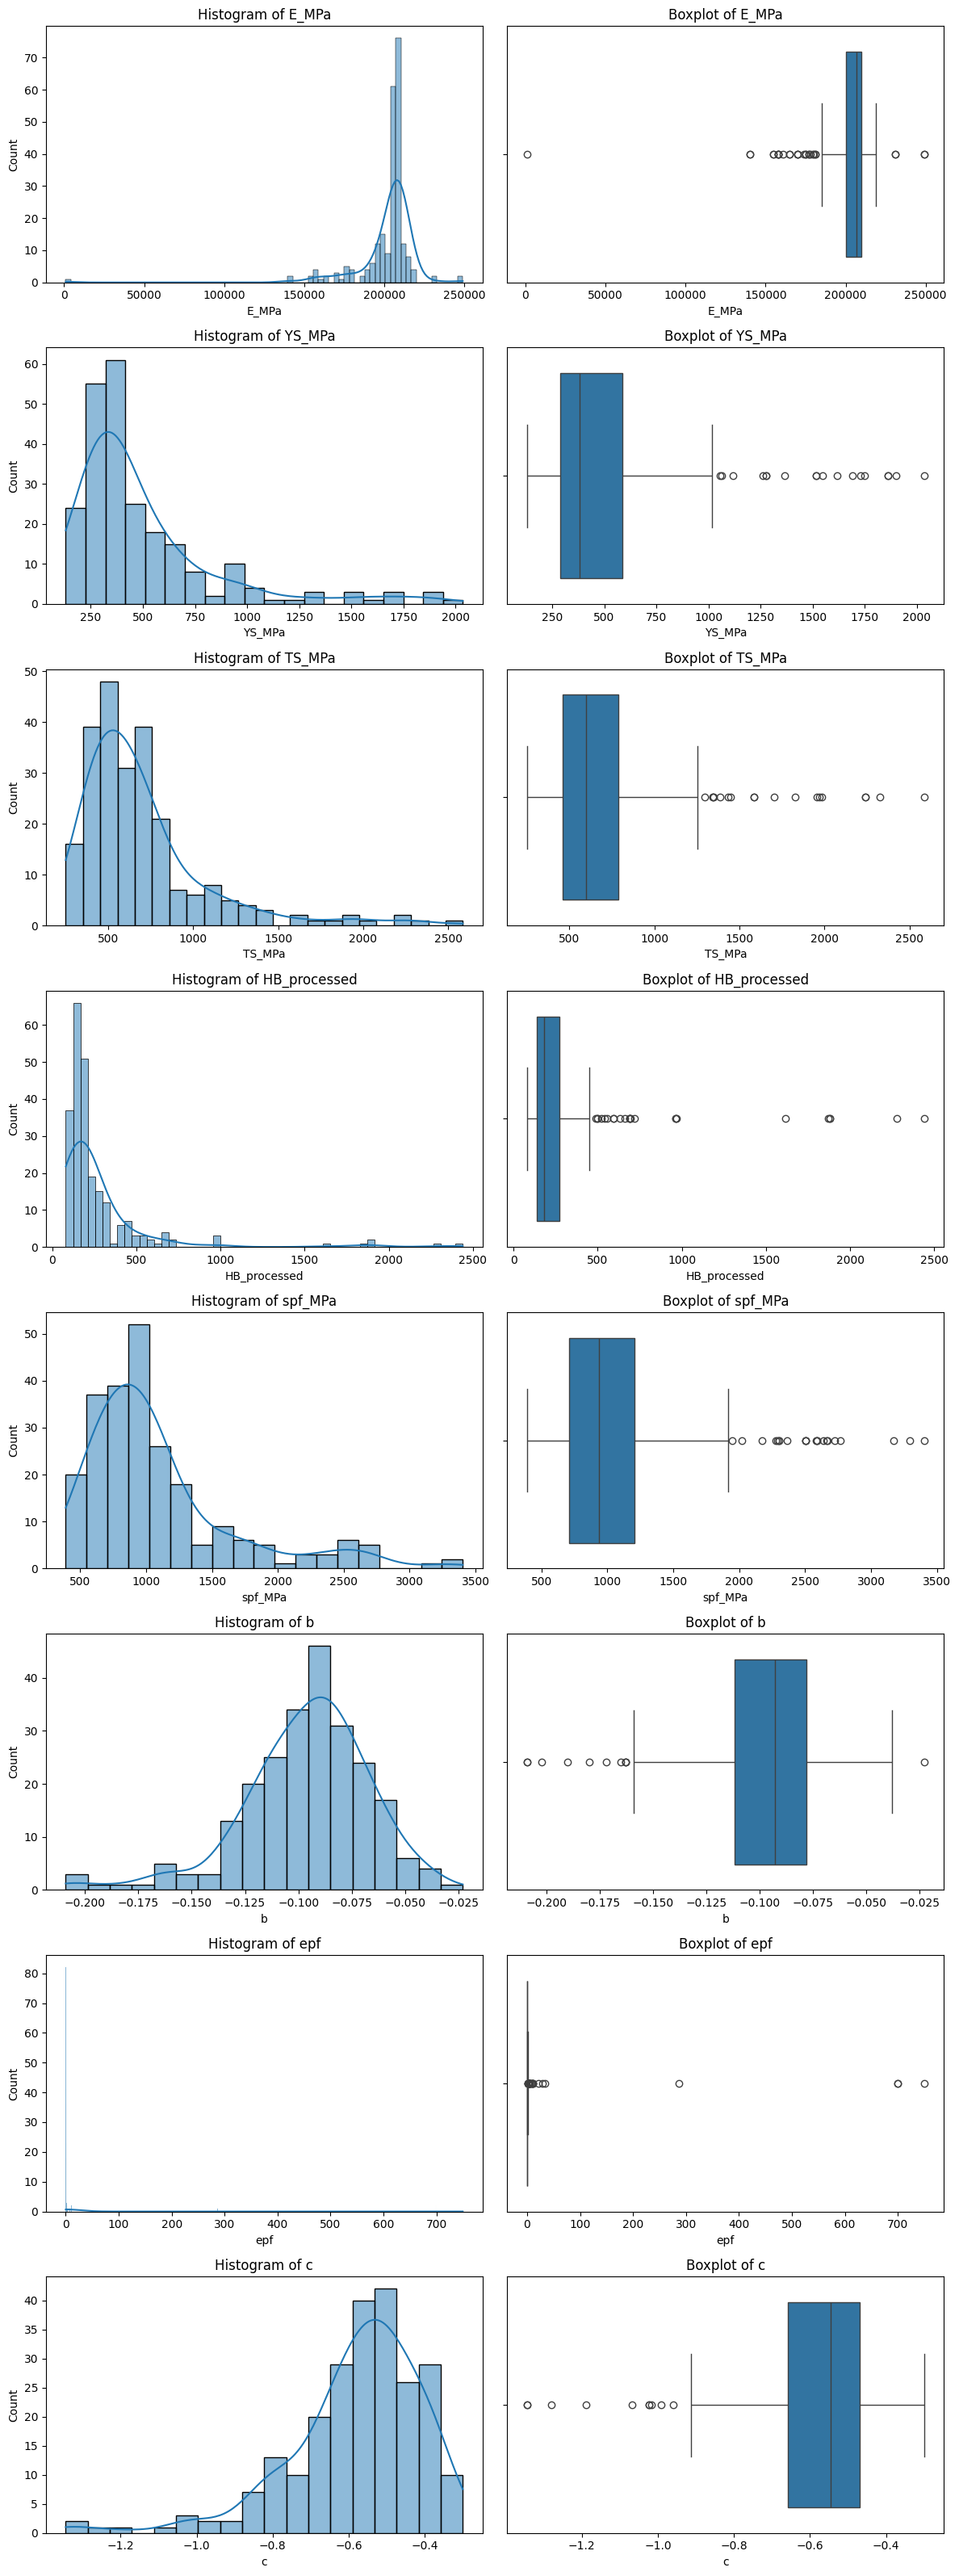


Calculating and Plotting Correlation Matrix...


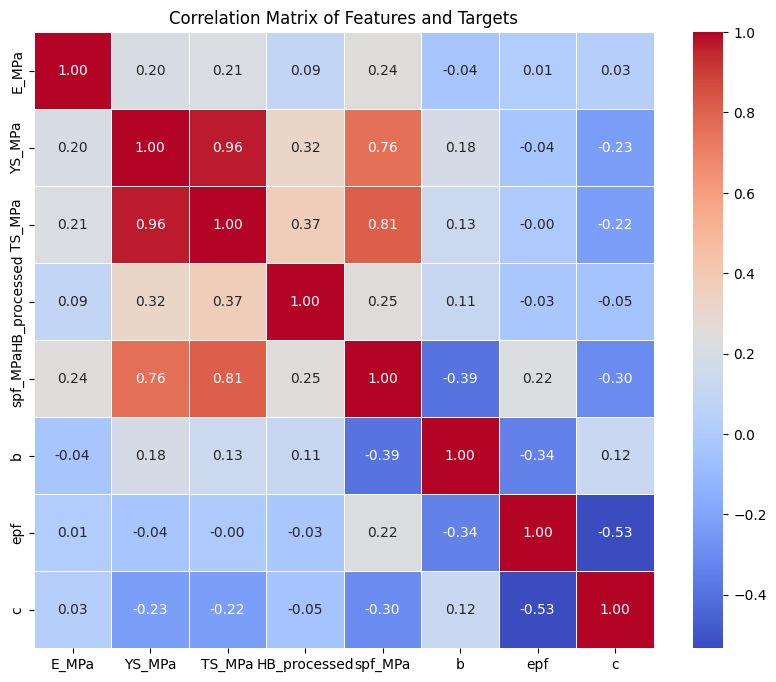


Analysis of target parameters:
Range of 'b': -0.209 -0.023
Range of 'c': -1.344 -0.3
Percentage of non-negative 'b': 0.00%
Percentage of non-negative 'c': 0.00%
Percentage where spf_MPa <= TS_MPa: 3.78%

Comparing distributions for imputed vs. non-imputed HB:


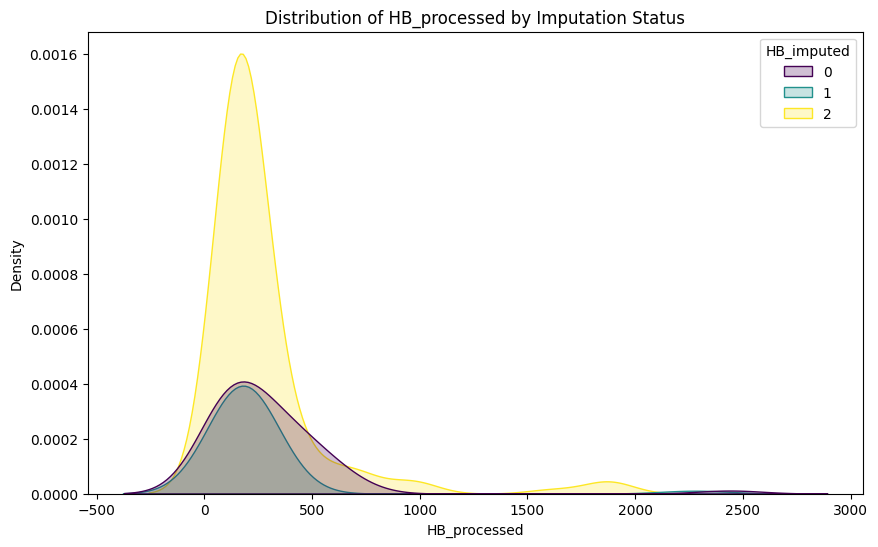

                spf_MPa         b        epf         c
HB_imputed                                            
0           1460.446429 -0.104964   0.434266 -0.564357
1            870.275000 -0.089025  19.416425 -0.528625
2           1010.712676 -0.094859  13.461020 -0.602070


In [11]:
# Cell 5: Exploratory Data Analysis (EDA)

print("\n--- Exploratory Data Analysis ---")

# 1. Descriptive Statistics
print("\nDescriptive Statistics (Features and Targets):")
print(df[feature_cols + target_cols].describe())

# 2. Distributions
print("\nPlotting Distributions...")
n_features = len(feature_cols)
n_targets = len(target_cols)
fig, axes = plt.subplots(n_features + n_targets, 2, figsize=(12, 4 * (n_features + n_targets)))

for i, col in enumerate(feature_cols + target_cols):
    sns.histplot(df[col], kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Histogram of {col}')
    sns.boxplot(x=df[col], ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

# 3. Correlation Matrix
print("\nCalculating and Plotting Correlation Matrix...")
correlation_matrix = df[feature_cols + target_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Features and Targets')
plt.show()

# 4. Pair Plots (optional, can be slow for many features)
# print("\nGenerating Pair Plot...")
# sns.pairplot(df[feature_cols + target_cols])
# plt.suptitle('Pair Plot of Features and Targets', y=1.02)
# plt.show()

# 5. Analysis of Target Parameters (Physical Plausibility)
print("\nAnalysis of target parameters:")
print("Range of 'b':", df['b'].min(), df['b'].max())
print("Range of 'c':", df['c'].min(), df['c'].max())
# Check if b and c are typically negative as expected
print(f"Percentage of non-negative 'b': { (df['b'] >= 0).mean() * 100:.2f}%")
print(f"Percentage of non-negative 'c': { (df['c'] >= 0).mean() * 100:.2f}%")
# Check relationship between spf and TS (spf is often > TS)
print(f"Percentage where spf_MPa <= TS_MPa: { (df['spf_MPa'] <= df['TS_MPa']).mean() * 100:.2f}%")

# Analysis based on HB imputation
print("\nComparing distributions for imputed vs. non-imputed HB:")
if hb_imputed_flag_col in df.columns and df[hb_imputed_flag_col].nunique() > 1:
     plt.figure(figsize=(10, 6))
     sns.kdeplot(data=df, x=hb_processed_col, hue=hb_imputed_flag_col, fill=True, palette='viridis')
     plt.title('Distribution of HB_processed by Imputation Status')
     plt.show()

     # Compare target means based on imputation status
     print(df.groupby(hb_imputed_flag_col)[target_cols].mean())
else:
    print("No HB imputation performed or only one status present.")

In [12]:
# Cell 6: Data Preparation for PyTorch

# Select final features (X) and targets (y)
X = df[feature_cols].values
y = df[target_cols].values
E_for_loss = df['E_MPa'].values # Keep E separately in original units for physics loss

print(f"Features shape (X): {X.shape}")
print(f"Targets shape (y): {y.shape}")
print(f"E for loss shape: {E_for_loss.shape}")


# 1. Train-Validation-Test Split
# Split ratio: e.g., 70% train, 15% validation, 15% test
X_train_val, X_test, y_train_val, y_test, E_train_val, E_test = train_test_split(
    X, y, E_for_loss, test_size=0.15, random_state=seed)
X_train, X_val, y_train, y_val, E_train, E_val = train_test_split(
    X_train_val, y_train_val, E_train_val, test_size=0.1765, random_state=seed) # 0.1765 * 0.85 ≈ 0.15

print(f"Train set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# 2. Scaling
# Scale features (X)
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

# Scale targets (y) - Often beneficial for training stability
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled = scaler_y.transform(y_val)
y_test_scaled = scaler_y.transform(y_test) # Will be used for final evaluation

# Save the scalers
joblib.dump(scaler_X, 'scaler_X.pkl')
joblib.dump(scaler_y, 'scaler_y.pkl')
print("Features and targets scaled. Scalers saved.")

# 3. Create PyTorch Datasets and DataLoaders
batch_size = 16 # Adjust as needed

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
E_train_tensor = torch.tensor(E_train, dtype=torch.float32).unsqueeze(1) # Add dimension for broadcasting

X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_scaled, dtype=torch.float32)
E_val_tensor = torch.tensor(E_val, dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32) # Scaled targets for evaluation
E_test_tensor = torch.tensor(E_test, dtype=torch.float32).unsqueeze(1)
y_test_orig_tensor = torch.tensor(y_test, dtype=torch.float32) # Original targets for comparison


# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor, E_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor, E_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor, E_test_tensor, y_test_orig_tensor) # Include original test targets

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("PyTorch Datasets and DataLoaders created.")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Features shape (X): (238, 4)
Targets shape (y): (238, 4)
E for loss shape: (238,)
Train set size: 166
Validation set size: 36
Test set size: 36
Features and targets scaled. Scalers saved.
PyTorch Datasets and DataLoaders created.
Number of training batches: 11
Number of validation batches: 3
Number of test batches: 3


In [13]:
# Cell 7: PINN Model Definition

class FatiguePINN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=[64, 128, 64]):
        """
        Args:
            input_dim (int): Number of input features (e.g., E, YS, TS, HB_processed)
            output_dim (int): Number of output parameters (e.g., spf, b, epf, c -> 4)
            hidden_dims (list): List of integers specifying the size of each hidden layer.
        """
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        layers = []
        last_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(last_dim, hidden_dim))
            layers.append(nn.ReLU()) # Or nn.Tanh()
            # layers.append(nn.Dropout(0.1)) # Optional: Add dropout for regularization
            last_dim = hidden_dim

        layers.append(nn.Linear(last_dim, output_dim))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        """
        Input x: Scaled features tensor (batch_size, input_dim)
        Returns: Scaled predicted parameters tensor (batch_size, output_dim)
        """
        return self.network(x)

# Instantiate the model
input_dim = X_train_scaled.shape[1]
output_dim = y_train_scaled.shape[1]
hidden_dims = [128, 256, 128] # Example architecture, tune as needed
model = FatiguePINN(input_dim, output_dim, hidden_dims).to(device)

print("PINN Model Definition:")
print(model)

# Quick test: Pass a dummy batch through the model
dummy_input = torch.randn(batch_size, input_dim).to(device)
dummy_output = model(dummy_input)
print(f"\nDummy input shape: {dummy_input.shape}")
print(f"Dummy output shape: {dummy_output.shape}")

PINN Model Definition:
FatiguePINN(
  (network): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=4, bias=True)
  )
)

Dummy input shape: torch.Size([16, 4])
Dummy output shape: torch.Size([16, 4])


In [14]:
# Cell 8: Loss Function Definition (PINN)

def pinn_loss_function(model_outputs_scaled, targets_scaled, E_unscaled, scaler_y, lambda_physics=0.1, num_physics_points=20, Nf_min=1e1, Nf_max=1e7, device='cpu'):
    """
    Calculates the combined Data and Physics loss for the Fatigue PINN.

    Args:
        model_outputs_scaled (torch.Tensor): Scaled parameter predictions from the model [spf', b', epf', c']_scaled. Shape: (batch_size, output_dim)
        targets_scaled (torch.Tensor): Scaled target parameters from data [spf, b, epf, c]_scaled. Shape: (batch_size, output_dim)
        E_unscaled (torch.Tensor): Elastic Modulus (in MPa) for the batch. Shape: (batch_size, 1)
        scaler_y (StandardScaler): Fitted scaler for the target parameters.
        lambda_physics (float): Weighting factor for the physics loss component.
        num_physics_points (int): Number of 2Nf points to generate for physics loss calculation.
        Nf_min (float): Minimum number of reversals (2Nf) for physics loss calculation.
        Nf_max (float): Maximum number of reversals (2Nf) for physics loss calculation.
        device (str): Device ('cpu', 'cuda', 'mps')

    Returns:
        tuple: (total_loss, data_loss, physics_loss)
    """
    # 1. Data Loss (MSE on scaled parameters)
    data_loss_fn = nn.MSELoss()
    data_loss = data_loss_fn(model_outputs_scaled, targets_scaled)

    # 2. Physics Loss (Coffin-Manson)
    # Inverse transform the *predicted* parameters to their original scale
    # Ensure model_outputs_scaled is on cpu for scaler if scaler was fit on cpu numpy arrays
    model_outputs_unscaled_np = scaler_y.inverse_transform(model_outputs_scaled.detach().cpu().numpy())
    model_outputs_unscaled = torch.tensor(model_outputs_unscaled_np, dtype=torch.float32).to(device)

    # Extract unscaled predicted parameters
    spf_pred = model_outputs_unscaled[:, 0].unsqueeze(1) # Shape: (batch_size, 1)
    b_pred = model_outputs_unscaled[:, 1].unsqueeze(1)
    epf_pred = model_outputs_unscaled[:, 2].unsqueeze(1)
    c_pred = model_outputs_unscaled[:, 3].unsqueeze(1)

    # Generate logarithmically spaced reversal points (2Nf) for physics loss calculation
    # Shape: (1, num_physics_points) - unsqueeze for broadcasting
    reversals = torch.logspace(torch.log10(torch.tensor(Nf_min)), torch.log10(torch.tensor(Nf_max)), num_physics_points).unsqueeze(0).to(device)

    # Calculate predicted strain amplitude using Coffin-Manson for each reversal point
    # E_unscaled needs to be broadcastable (batch_size, 1)
    # Parameters need to be broadcastable (batch_size, 1)
    # Reversals need to be broadcastable (1, num_physics_points)
    # Resulting shape: (batch_size, num_physics_points)
    epsilon_a_pred = (spf_pred / E_unscaled) * (reversals ** b_pred) + epf_pred * (reversals ** c_pred)

    # --- How to define the 'true' physics target? ---
    # Option A: Use target parameters from data to calculate 'true' strain
    # Inverse transform the *target* parameters to their original scale
    targets_unscaled_np = scaler_y.inverse_transform(targets_scaled.detach().cpu().numpy())
    targets_unscaled = torch.tensor(targets_unscaled_np, dtype=torch.float32).to(device)
    spf_true = targets_unscaled[:, 0].unsqueeze(1)
    b_true = targets_unscaled[:, 1].unsqueeze(1)
    epf_true = targets_unscaled[:, 2].unsqueeze(1)
    c_true = targets_unscaled[:, 3].unsqueeze(1)
    epsilon_a_true = (spf_true / E_unscaled) * (reversals ** b_true) + epf_true * (reversals ** c_true)

    # Option B: Use simplified physics constraints (e.g., b<0, c<0) - Simpler to start
    # penalty_b = torch.mean(torch.relu(b_pred)) # Penalize positive b
    # penalty_c = torch.mean(torch.relu(c_pred)) # Penalize positive c
    # physics_loss = penalty_b + penalty_c

    # --- Implementing Option A ---
    physics_loss = torch.mean((epsilon_a_pred - epsilon_a_true)**2)

    # --- Implementing Option B (Example) ---
    # penalty_b = torch.mean(torch.relu(b_pred))
    # penalty_c = torch.mean(torch.relu(c_pred))
    # physics_loss = penalty_b + penalty_c + torch.mean(torch.relu(TS_unscaled.unsqueeze(1) - spf_pred)) # Penalize if spf < TS

    # 3. Total Loss
    total_loss = data_loss + lambda_physics * physics_loss

    return total_loss, data_loss, physics_loss

# --- Test the loss function ---
# Get a sample batch from the train_loader
sample_X, sample_y_scaled, sample_E = next(iter(train_loader))
sample_X, sample_y_scaled, sample_E = sample_X.to(device), sample_y_scaled.to(device), sample_E.to(device)

# Pass through model
model.eval() # Set model to evaluation mode for consistency during test
with torch.no_grad():
     sample_output_scaled = model(sample_X)

# Calculate loss
# Use a dummy lambda for testing
total_loss, data_loss, physics_loss = pinn_loss_function(
    sample_output_scaled, sample_y_scaled, sample_E, scaler_y, lambda_physics=0.01, device=device
)

print(f"\nTesting Loss Function:")
print(f"  Sample Output (scaled) shape: {sample_output_scaled.shape}")
print(f"  Sample Target (scaled) shape: {sample_y_scaled.shape}")
print(f"  Sample E (unscaled) shape: {sample_E.shape}")
print(f"  Calculated Total Loss: {total_loss.item():.4f}")
print(f"  Calculated Data Loss: {data_loss.item():.4f}")
print(f"  Calculated Physics Loss: {physics_loss.item():.4f}")

# Choose your physics loss weight (lambda) - This requires tuning!
lambda_physics_value = 0.01 # Start with a small value and tune based on validation performance


Testing Loss Function:
  Sample Output (scaled) shape: torch.Size([16, 4])
  Sample Target (scaled) shape: torch.Size([16, 4])
  Sample E (unscaled) shape: torch.Size([16, 1])
  Calculated Total Loss: 0.5767
  Calculated Data Loss: 0.5748
  Calculated Physics Loss: 0.1891



--- Starting Training ---
Epochs: 200, LR: 0.001, Lambda_Physics: 0.01, Patience: 20
Epoch [1/200], Train Loss: 0.3494 (Data: 0.3340, Phys: 1.5408), Val Loss: 0.4767 (Data: 0.4575, Phys: 1.9249)
  Validation loss improved. Saved best model.
Epoch [2/200], Train Loss: 0.5054 (Data: 0.4823, Phys: 2.3046), Val Loss: 0.4653 (Data: 0.4475, Phys: 1.7884)
  Validation loss improved. Saved best model.
Epoch [3/200], Train Loss: 0.3492 (Data: 0.3279, Phys: 2.1349), Val Loss: 0.5531 (Data: 0.5017, Phys: 5.1399)
  Validation loss did not improve for 1 epoch(s).
Epoch [4/200], Train Loss: 0.3393 (Data: 0.3126, Phys: 2.6664), Val Loss: 0.5111 (Data: 0.4795, Phys: 3.1632)
  Validation loss did not improve for 2 epoch(s).
Epoch [5/200], Train Loss: 0.3152 (Data: 0.3028, Phys: 1.2403), Val Loss: 0.4777 (Data: 0.4555, Phys: 2.2208)
  Validation loss did not improve for 3 epoch(s).
Epoch [6/200], Train Loss: 0.3245 (Data: 0.3081, Phys: 1.6402), Val Loss: 0.5209 (Data: 0.5028, Phys: 1.8099)
  Validation

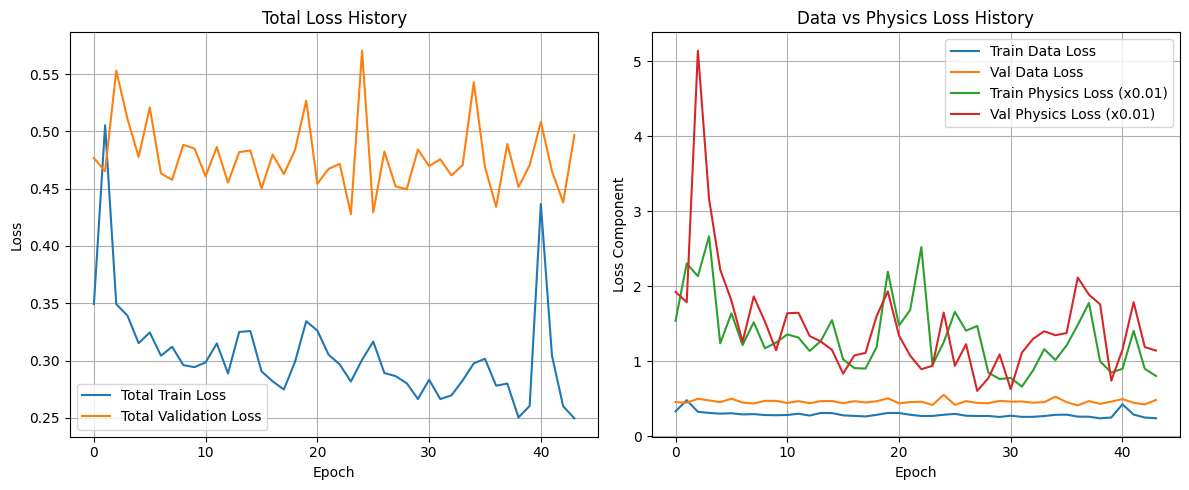

In [23]:
# Cell 9: Training Loop

# Hyperparameters
learning_rate = 0.001
epochs = 200 # Adjust as needed
patience = 20 # For early stopping

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5) # Optional LR scheduler

# Early stopping parameters
best_val_loss = float('inf')
epochs_no_improve = 0

# Lists to store loss history
train_loss_history = []
val_loss_history = []
train_data_loss_hist = []
train_phys_loss_hist = []
val_data_loss_hist = []
val_phys_loss_hist = []


print(f"\n--- Starting Training ---")
print(f"Epochs: {epochs}, LR: {learning_rate}, Lambda_Physics: {lambda_physics_value}, Patience: {patience}")

for epoch in range(epochs):
    model.train() # Set model to training mode
    train_epoch_loss = 0.0
    train_epoch_data_loss = 0.0
    train_epoch_phys_loss = 0.0

    for batch_X, batch_y_scaled, batch_E in train_loader:
        batch_X, batch_y_scaled, batch_E = batch_X.to(device), batch_y_scaled.to(device), batch_E.to(device)

        # Forward pass
        outputs_scaled = model(batch_X)

        # Calculate loss
        loss, data_loss, phys_loss = pinn_loss_function(
            outputs_scaled, batch_y_scaled, batch_E, scaler_y, lambda_physics=lambda_physics_value, device=device
        )

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_epoch_loss += loss.item()
        train_epoch_data_loss += data_loss.item()
        train_epoch_phys_loss += phys_loss.item()

    # Calculate average epoch losses
    avg_train_loss = train_epoch_loss / len(train_loader)
    avg_train_data_loss = train_epoch_data_loss / len(train_loader)
    avg_train_phys_loss = train_epoch_phys_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)
    train_data_loss_hist.append(avg_train_data_loss)
    train_phys_loss_hist.append(avg_train_phys_loss)

    # Validation phase
    model.eval() # Set model to evaluation mode
    val_epoch_loss = 0.0
    val_epoch_data_loss = 0.0
    val_epoch_phys_loss = 0.0
    with torch.no_grad():
        for batch_X_val, batch_y_val_scaled, batch_E_val in val_loader:
            batch_X_val, batch_y_val_scaled, batch_E_val = batch_X_val.to(device), batch_y_val_scaled.to(device), batch_E_val.to(device)

            outputs_val_scaled = model(batch_X_val)
            val_loss, val_data_loss, val_phys_loss = pinn_loss_function(
                 outputs_val_scaled, batch_y_val_scaled, batch_E_val, scaler_y, lambda_physics=lambda_physics_value, device=device
            )
            val_epoch_loss += val_loss.item()
            val_epoch_data_loss += val_data_loss.item()
            val_epoch_phys_loss += val_phys_loss.item()

    avg_val_loss = val_epoch_loss / len(val_loader)
    avg_val_data_loss = val_epoch_data_loss / len(val_loader)
    avg_val_phys_loss = val_epoch_phys_loss / len(val_loader)
    val_loss_history.append(avg_val_loss)
    val_data_loss_hist.append(avg_val_data_loss)
    val_phys_loss_hist.append(avg_val_phys_loss)

    # Optional: Learning rate scheduling step
    # scheduler.step(avg_val_loss)

    print(f"Epoch [{epoch+1}/{epochs}], "
          f"Train Loss: {avg_train_loss:.4f} (Data: {avg_train_data_loss:.4f}, Phys: {avg_train_phys_loss:.4f}), "
          f"Val Loss: {avg_val_loss:.4f} (Data: {avg_val_data_loss:.4f}, Phys: {avg_val_phys_loss:.4f})")

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_fatigue_pinn_model.pth')
        print(f"  Validation loss improved. Saved best model.")
    else:
        epochs_no_improve += 1
        print(f"  Validation loss did not improve for {epochs_no_improve} epoch(s).")

    if epochs_no_improve >= patience:
        print(f"\nEarly stopping triggered after {epoch+1} epochs.")
        break

print("\n--- Training Complete ---")

# Plot loss history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Total Train Loss')
plt.plot(val_loss_history, label='Total Validation Loss')
plt.title('Total Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_data_loss_hist, label='Train Data Loss')
plt.plot(val_data_loss_hist, label='Val Data Loss')
plt.plot(train_phys_loss_hist, label=f'Train Physics Loss (x{lambda_physics_value:.2f})')
plt.plot(val_phys_loss_hist, label=f'Val Physics Loss (x{lambda_physics_value:.2f})')
plt.title('Data vs Physics Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss Component')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


--- Evaluating on Test Set ---

Test Set Performance (Original Scale):
  spf_MPa:
    MSE: 175703.0625
    R2 Score: 0.5943
  b:
    MSE: 0.0012
    R2 Score: 0.1694
  epf:
    MSE: 9117.8877
    R2 Score: 0.3951
  c:
    MSE: 0.0391
    R2 Score: 0.1237

Plotting Predictions vs. Actuals...


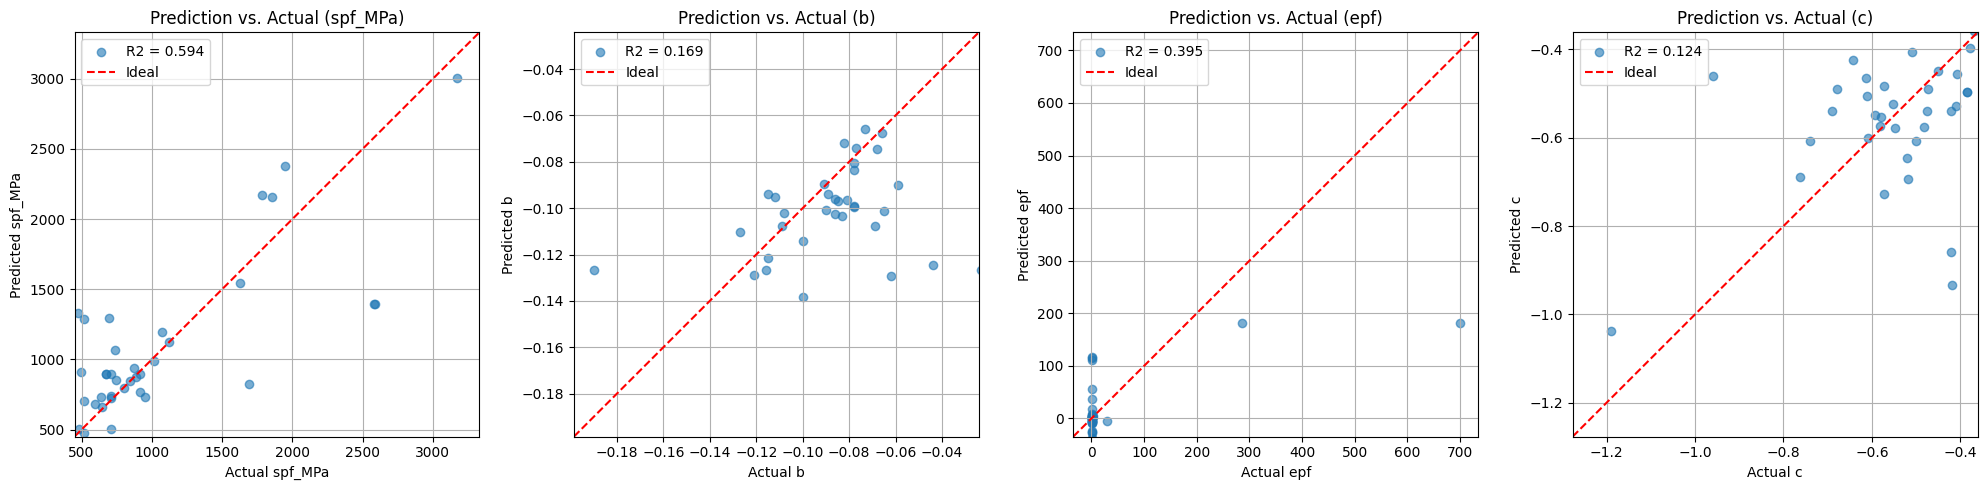

In [25]:
# Cell 10: Evaluation

# Load the best model saved during training
model.load_state_dict(torch.load('best_fatigue_pinn_model.pth', map_location=device))
model.eval() # Set to evaluation mode

all_preds_scaled = []
all_targets_scaled = []
all_targets_orig = []

print("\n--- Evaluating on Test Set ---")
with torch.no_grad():
    for batch_X_test, batch_y_test_scaled, batch_E_test, batch_y_test_orig in test_loader:
        batch_X_test, batch_y_test_scaled = batch_X_test.to(device), batch_y_test_scaled.to(device)

        # Predict scaled parameters
        outputs_test_scaled = model(batch_X_test)

        all_preds_scaled.append(outputs_test_scaled.cpu().numpy())
        all_targets_scaled.append(batch_y_test_scaled.cpu().numpy())
        all_targets_orig.append(batch_y_test_orig.cpu().numpy())

# Concatenate results from all batches
all_preds_scaled = np.concatenate(all_preds_scaled, axis=0)
all_targets_scaled = np.concatenate(all_targets_scaled, axis=0)
all_targets_orig = np.concatenate(all_targets_orig, axis=0)

# Inverse transform predictions to original scale
all_preds_orig = scaler_y.inverse_transform(all_preds_scaled)

# Calculate metrics for each parameter in original scale
metrics = {}
print("\nTest Set Performance (Original Scale):")
for i, param_name in enumerate(target_cols):
    param_pred = all_preds_orig[:, i]
    param_true = all_targets_orig[:, i]

    mse = mean_squared_error(param_true, param_pred)
    r2 = r2_score(param_true, param_pred)
    metrics[param_name] = {'MSE': mse, 'R2': r2}
    print(f"  {param_name}:")
    print(f"    MSE: {mse:.4f}")
    print(f"    R2 Score: {r2:.4f}")

# Visualize Predictions vs. Actuals
print("\nPlotting Predictions vs. Actuals...")
n_targets = len(target_cols)
fig, axes = plt.subplots(1, n_targets, figsize=(5 * n_targets, 5))
if n_targets == 1: axes = [axes] # Make iterable if only one target

for i, param_name in enumerate(target_cols):
    param_pred = all_preds_orig[:, i]
    param_true = all_targets_orig[:, i]

    min_val = min(param_pred.min(), param_true.min()) * 0.95
    max_val = max(param_pred.max(), param_true.max()) * 1.05

    axes[i].scatter(param_true, param_pred, alpha=0.6, label=f'R2 = {metrics[param_name]["R2"]:.3f}')
    axes[i].plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal')
    axes[i].set_xlabel(f'Actual {param_name}')
    axes[i].set_ylabel(f'Predicted {param_name}')
    axes[i].set_title(f'Prediction vs. Actual ({param_name})')
    axes[i].set_xlim(min_val, max_val)
    axes[i].set_ylim(min_val, max_val)
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()


--- Testing E-N Curve Generation ---
Example Input:
  E: 212000 MPa
  YS: 751 MPa
  TS: 1251 MPa
  HB: 309.0

Predicted Parameters:
  spf_MPa: 2379.7820
  b: -0.1288
  epf: -36.3962
  c: -0.4246


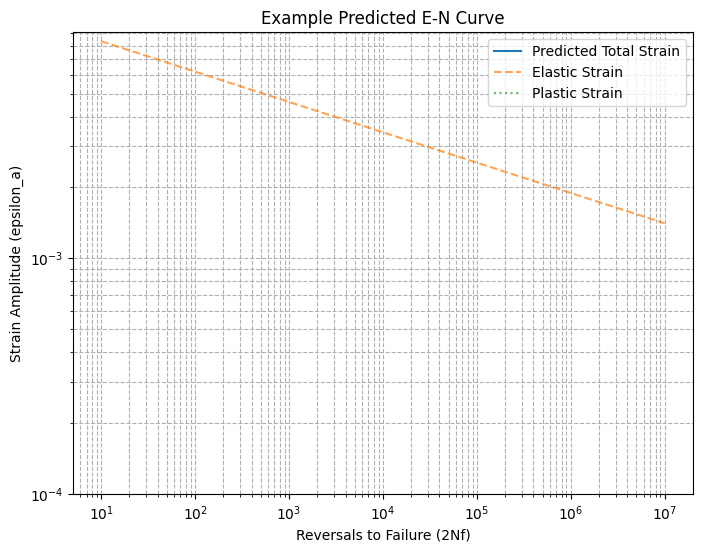

In [26]:
# Cell 11: E-N Curve Generation Function

def predict_fatigue_params_and_curve(E_val, YS_val, TS_val, HB_val, model, scaler_X, scaler_y, device):
    """
    Predicts fatigue parameters and generates E-N curve data for given inputs.

    Args:
        E_val (float): Elastic Modulus (MPa)
        YS_val (float): Yield Strength (MPa)
        TS_val (float): Ultimate Tensile Strength (MPa)
        HB_val (float): Brinell Hardness (processed/imputed if necessary)
        model (torch.nn.Module): Trained PINN model.
        scaler_X (StandardScaler): Fitted scaler for input features.
        scaler_y (StandardScaler): Fitted scaler for output parameters.
        device (str): Device ('cpu', 'cuda', 'mps')

    Returns:
        tuple: (predicted_params_dict, reversals, strain_amplitude)
               predicted_params_dict (dict): Dictionary of predicted parameters.
               reversals (np.array): Reversals to failure (2Nf).
               strain_amplitude (np.array): Total strain amplitude (epsilon_a).
    """
    model.eval() # Ensure model is in eval mode

    # Prepare input features
    input_features = np.array([[E_val, YS_val, TS_val, HB_val]])

    # Scale features
    input_scaled = scaler_X.transform(input_features)
    input_tensor = torch.tensor(input_scaled, dtype=torch.float32).to(device)

    # Predict scaled parameters
    with torch.no_grad():
        predicted_params_scaled = model(input_tensor)

    # Inverse transform predicted parameters
    predicted_params_orig = scaler_y.inverse_transform(predicted_params_scaled.cpu().numpy())[0]

    # Create dictionary of predicted parameters
    predicted_params_dict = {name: val for name, val in zip(target_cols, predicted_params_orig)}
    sigma_f_prime = predicted_params_dict['spf_MPa']
    b = predicted_params_dict['b']
    epsilon_f_prime = predicted_params_dict['epf']
    c = predicted_params_dict['c']

    # Generate E-N curve data using Coffin-Manson
    reversals = np.logspace(1, 7, num=100) # 10^1 to 10^7 reversals
    elastic_strain = (sigma_f_prime / E_val) * (reversals ** b)
    plastic_strain = epsilon_f_prime * (reversals ** c)
    total_strain_amplitude = elastic_strain + plastic_strain

    return predicted_params_dict, reversals, total_strain_amplitude

# --- Test the function ---
print("\n--- Testing E-N Curve Generation ---")
# Use the first sample from the test set as an example
example_input_X = X_test[0] # Original scale features
example_E = E_test[0]

# Get HB value correctly from the feature array (it's the last one)
example_HB = example_input_X[-1]

print(f"Example Input:")
print(f"  E: {example_E:.0f} MPa")
print(f"  YS: {example_input_X[1]:.0f} MPa")
print(f"  TS: {example_input_X[2]:.0f} MPa")
print(f"  HB: {example_HB:.1f}")


predicted_params, reversals, strain_amplitude = predict_fatigue_params_and_curve(
    example_E, example_input_X[1], example_input_X[2], example_HB,
    model, scaler_X, scaler_y, device
)

print("\nPredicted Parameters:")
for name, val in predicted_params.items():
    print(f"  {name}: {val:.4f}")


# Plot the generated curve
plt.figure(figsize=(8, 6))
plt.loglog(reversals, strain_amplitude, label='Predicted Total Strain')
# Optional: Plot components
sigma_f_prime_pred = predicted_params['spf_MPa']
b_pred = predicted_params['b']
epsilon_f_prime_pred = predicted_params['epf']
c_pred = predicted_params['c']
plt.loglog(reversals, (sigma_f_prime_pred / example_E) * (reversals ** b_pred), '--', label='Elastic Strain', alpha=0.7)
plt.loglog(reversals, epsilon_f_prime_pred * (reversals ** c_pred), ':', label='Plastic Strain', alpha=0.7)

plt.xlabel('Reversals to Failure (2Nf)')
plt.ylabel('Strain Amplitude (epsilon_a)')
plt.title('Example Predicted E-N Curve')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.ylim(bottom=1e-4) # Adjust ylim if needed
plt.show()

In [ ]:
# Cell 12: GUI Considerations (Streamlit Example)

# This cell provides a basic structure for a Streamlit app.
# To run this, save the code as a .py file (e.g., app.py) and run `streamlit run app.py` in your terminal.
# You would need to ensure the trained model (.pth) and scalers (.pkl) are in the same directory or provide correct paths.
# Also, the predict_fatigue_params_and_curve function needs to be defined or imported in the app script.

streamlit_code = """
import streamlit as st
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn # Need model definition
import joblib
import os # To check file existence

# --- Replicate Model Definition ---
# It's best practice to have model definition in a separate .py file and import it.
# For simplicity here, we might redefine it or assume it's available.
class FatiguePINN(nn.Module): # Copy the exact definition from Cell 7
    def __init__(self, input_dim, output_dim, hidden_dims=[128, 256, 128]): # Use the same architecture
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        layers = []
        last_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(last_dim, hidden_dim))
            layers.append(nn.ReLU())
            last_dim = hidden_dim
        layers.append(nn.Linear(last_dim, output_dim))
        self.network = nn.Sequential(*layers)
    def forward(self, x):
        return self.network(x)

# --- Replicate Prediction Function ---
# Or import from a utility file
def predict_fatigue_params_and_curve(E_val, YS_val, TS_val, HB_val, model, scaler_X, scaler_y, device):
    # Copy the exact function from Cell 11
    model.eval()
    input_features = np.array([[E_val, YS_val, TS_val, HB_val]])
    input_scaled = scaler_X.transform(input_features)
    input_tensor = torch.tensor(input_scaled, dtype=torch.float32).to(device)
    with torch.no_grad():
        predicted_params_scaled = model(input_tensor)
    predicted_params_orig = scaler_y.inverse_transform(predicted_params_scaled.cpu().numpy())[0]
    target_cols = ['spf_MPa', 'b', 'epf', 'c'] # Ensure this matches training
    predicted_params_dict = {name: val for name, val in zip(target_cols, predicted_params_orig)}
    sigma_f_prime = predicted_params_dict['spf_MPa']
    b = predicted_params_dict['b']
    epsilon_f_prime = predicted_params_dict['epf']
    c = predicted_params_dict['c']
    reversals = np.logspace(1, 7, num=100)
    # Check for potential division by zero or invalid E_val
    if E_val <= 0: E_val = 1e-6 # Avoid division by zero, maybe handle better
    elastic_strain = (sigma_f_prime / E_val) * (reversals ** b)
    plastic_strain = epsilon_f_prime * (reversals ** c)
    total_strain_amplitude = elastic_strain + plastic_strain
    return predicted_params_dict, reversals, total_strain_amplitude


# --- Load Model and Scalers ---
@st.cache_resource # Cache resource loading
def load_resources(model_path='best_fatigue_pinn_model.pth', scaler_x_path='scaler_X.pkl', scaler_y_path='scaler_y.pkl'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

    # Check if files exist
    if not os.path.exists(model_path) or not os.path.exists(scaler_x_path) or not os.path.exists(scaler_y_path):
        st.error("Error: Model or scaler files not found. Make sure they are in the correct directory.")
        return None, None, None, None

    try:
        scaler_X = joblib.load(scaler_x_path)
        scaler_y = joblib.load(scaler_y_path)

        # Determine model input/output dims from scalers
        input_dim = scaler_X.n_features_in_
        output_dim = scaler_y.n_features_in_

        # Instantiate model with correct dims
        model = FatiguePINN(input_dim, output_dim).to(device) # Use the saved architecture's hidden dims if possible/needed
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()

        return model, scaler_X, scaler_y, device
    except Exception as e:
        st.error(f"Error loading resources: {e}")
        return None, None, None, None

# --- Streamlit App Layout ---
st.set_page_config(layout="wide")
st.title('Metallic Material Fatigue Life (E-N Curve) Predictor')
st.write("Enter material properties to predict the tensile fatigue parameters and E-N curve using a PINN model.")

# Load resources
model, scaler_X, scaler_y, device = load_resources()

if model is None: # Stop if resources failed to load
    st.stop()


# Input section
col1, col2 = st.columns([1, 2])

with col1:
    st.header("Material Properties Input")
    e_mod = st.number_input('Elastic Modulus (E, MPa)', min_value=1.0, value=200000.0, format='%.1f')
    ys = st.number_input('Yield Strength (YS, MPa)', min_value=1.0, value=500.0, format='%.1f')
    ts = st.number_input('Ultimate Tensile Strength (UTS, MPa)', min_value=1.0, value=700.0, format='%.1f')
    hb_input = st.number_input('Brinell Hardness (HB)', min_value=0.0, value=200.0, format='%.1f', help="Enter 0 or leave blank if unknown (model will attempt imputation).")

    # Handle unknown HB - Basic strategy: Use average HB from training data scaler if 0
    # A more robust approach would use the saved HB imputer model if HB is 0.
    hb_processed = hb_input
    if hb_input == 0.0:
         try:
            # Assuming HB was the last feature scaled by scaler_X
            hb_mean_from_scaler = scaler_X.mean_[-1]
            hb_processed = hb_mean_from_scaler
            st.info(f"HB not provided. Using average HB from training data: {hb_processed:.1f}")
         except Exception:
             st.warning("Could not retrieve mean HB. Using input value 0. Prediction might be inaccurate.")
             hb_processed = 0.1 # Use a small non-zero value if needed by model

    predict_button = st.button('Predict E-N Curve')

# Output section
with col2:
    st.header("Prediction Results")
    if predict_button:
        if e_mod <= 0 or ys <= 0 or ts <= 0:
            st.error("Please enter valid positive values for E, YS, and TS.")
        elif ys > ts * 1.05: # Allow slightly higher YS than TS
            st.warning("Yield Strength (YS) seems high compared to Ultimate Tensile Strength (UTS). Please verify.")
        else:
            try:
                predicted_params, reversals, strain_amplitude = predict_fatigue_params_and_curve(
                    e_mod, ys, ts, hb_processed, model, scaler_X, scaler_y, device
                )

                st.subheader("Predicted Fatigue Parameters:")
                param_df = pd.DataFrame(list(predicted_params.items()), columns=['Parameter', 'Value'])
                st.dataframe(param_df.style.format({'Value': '{:.4f}'}))

                st.subheader("Predicted E-N Curve:")
                fig, ax = plt.subplots(figsize=(8, 6))
                ax.loglog(reversals, strain_amplitude, label='Predicted Total Strain')

                # Plot components if desired
                sigma_f_prime_pred = predicted_params['spf_MPa']
                b_pred = predicted_params['b']
                epsilon_f_prime_pred = predicted_params['epf']
                c_pred = predicted_params['c']
                ax.loglog(reversals, (sigma_f_prime_pred / e_mod) * (reversals ** b_pred), '--', label='Elastic', alpha=0.7)
                ax.loglog(reversals, epsilon_f_prime_pred * (reversals ** c_pred), ':', label='Plastic', alpha=0.7)

                ax.set_xlabel('Reversals to Failure (2Nf)')
                ax.set_ylabel('Strain Amplitude (epsilon_a)')
                ax.set_title('Predicted E-N Curve')
                ax.legend()
                ax.grid(True, which="both", ls="--")
                ax.set_ylim(bottom=max(1e-5, min(strain_amplitude)*0.5), top=max(strain_amplitude)*1.2) # Dynamic y-limits
                st.pyplot(fig)

            except Exception as e:
                st.error(f"An error occurred during prediction: {e}")
                # Optionally print more detailed traceback for debugging
                # import traceback
                # st.text(traceback.format_exc())

    else:
        st.info("Enter material properties and click 'Predict E-N Curve'.")

"""

# To run this Streamlit app:
# 1. Save the code above into a file named (for example) `fatigue_app.py`.
# 2. Make sure 'best_fatigue_pinn_model.pth', 'scaler_X.pkl', and 'scaler_y.pkl' are in the same directory.
# 3. Open your terminal, navigate to that directory.
# 4. Run the command: streamlit run fatigue_app.py

print("\nStreamlit app code generated. Save it to a .py file and run with `streamlit run <filename>.py`")
# print(streamlit_code) # Optionally print the code here